In [1]:
from pokerl.env.pokemonblue import PokemonBlueEnv

In [2]:
env = PokemonBlueEnv()

In [4]:
for i in range(1000):
    env.step(4)

In [5]:
for i in range(1000):
    env.tick()

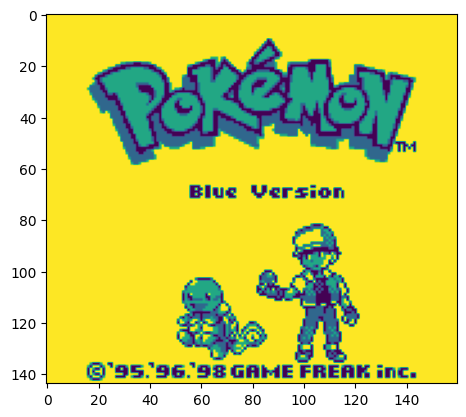

In [6]:
from matplotlib import pyplot as plt    
plt.imshow(env.render())

In [7]:
env.render().shape

(144, 160)

In [8]:
import torch
import torchvision

x = torch.tensor(env.render())

In [9]:
x = torchvision.transforms.Resize((128, 128)).forward(x.unsqueeze(0)).squeeze(0)

/Users/baptistepugnaire/Documents/Projects/GitHub/pokeRL/.venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


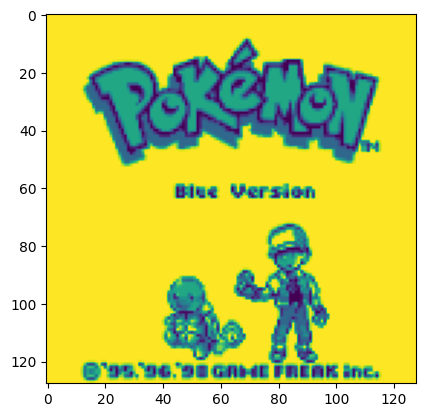

In [10]:
plt.imshow(x)

In [11]:
x = torch.tensor(env.render())
x=x.float() 
x = x.unsqueeze(0)  # Add a channel dimension

normalizer = torchvision.transforms.Normalize(mean=[0], std=[1])
x = normalizer.forward(x)

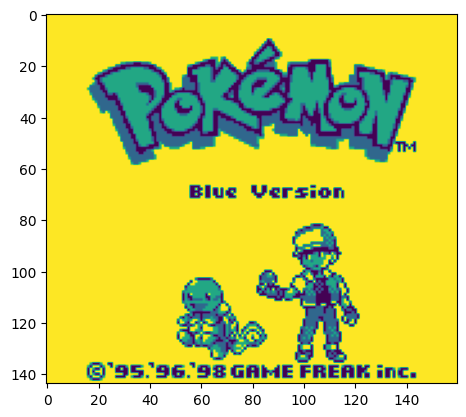

In [12]:
plt.imshow(x.permute(1, 2, 0)  )


In [13]:
grey_scaler= torchvision.transforms.Grayscale()
x  = grey_scaler.forward(x)
x = torchvision.transforms.Resize((128, 128)).forward(x)

In [14]:
from pokerl.agent.own_dreamer.nets.image_encoder import ImageEncoderResnet
ImageEncoderResnet(10, 3, (1,128,128), 2)


ImageEncoderResnet(
  (_convs): ModuleList(
    (0): Conv2d(1, 10, kernel_size=(4, 4), stride=(2, 2))
    (1): Conv2d(10, 20, kernel_size=(4, 4), stride=(2, 2))
    (2): Conv2d(20, 40, kernel_size=(4, 4), stride=(2, 2))
    (3): Conv2d(40, 80, kernel_size=(4, 4), stride=(2, 2))
    (4): Conv2d(80, 160, kernel_size=(4, 4), stride=(2, 2))
    (5): Conv2d(160, 320, kernel_size=(4, 4), stride=(2, 2))
  )
)

In [15]:
ImageEncoderResnet(10, 3, (1,128,128), 2).forward(x)


NotImplementedError: Module [ImageEncoderResnet] is missing the required "forward" function

In [9]:
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim

# Define the Deep Q-Network (DQN) model
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.cn1 = nn.Conv2d(state_size[0], state_size[1], kernel_size=3, stride=1, padding=1) 
        self.fc1 = nn.Linear(, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3 = nn.Linear(24, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the Deep Q-Learning Agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = DQN(state_size, action_size).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.tensor(state, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            q_values = self.model(state)
        return torch.argmax(q_values).item()

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)
        states = torch.tensor(states, dtype=torch.float32).to(self.device)
        actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(self.device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(self.device)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(self.device)

        q_values = self.model(states).gather(1, actions)
        next_q_values = self.model(next_states).max(1)[0].unsqueeze(1)
        targets = rewards + self.gamma * next_q_values * (1 - dones)

        loss = self.criterion(q_values, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Initialize the environment and agent
env = PokemonBlueGym()
state_size = env._get_observation().shape[0]
action_size = len(GameboyAction)
agent = DQNAgent(state_size, action_size)

# Train the agent
batch_size = 32
num_episodes = 1000
for episode in range(num_episodes):
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
    agent.replay(batch_size)
    print("Episode: {}, Total Reward: {}".format(episode+1, total_reward))


AttributeError: 'PokemonBlueGym' object has no attribute '_kwargs'

In [25]:
env.screen